In [ ]:
"""
DATA INTEGRATION AND ANALYSIS NOTEBOOK

PURPOSE:
This notebook integrates cleaned NOAA GSOM climate data with USDA NASS corn production
data to analyze the relationship between growing season weather patterns and agricultural
outcomes in Illinois over 120+ years.

INPUTS:
gsom_annual_clean.csv: Annual growing season climate data (Fahrenheit, inches)
nass_cleaned.csv: Annual corn production metrics (acres, bushels/acre, bushels)

OUTPUT:
integrated_climate_corn.csv: Merged dataset ready for statistical analysis
Multiple visualizations showing climate-agriculture relationships
Statistical analysis results (correlations, regressions)

NOTE: This notebook does NOT acquire, clean, or alter any of the data utilized. Please refer to 
our documentation to understand the correct chronological order of reproduction.

AUTHORS: Brady Brooks, Aden Krueger
DATE: November 2054
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
cleaned_dir = os.path.join(project_root, "data", "cleaned")

#create dir for user if it does not exist
os.makedirs(cleaned_dir, exist_ok=True)
import warnings
warnings.filterwarnings('ignore')

# set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


try:
    df_climate = pd.read_csv("../data/cleaned/gsom_annual_clean.csv")
    print(f"Loaded climate data: {df_climate.shape}")
    print(f"Year range: {df_climate['year'].min()} - {df_climate['year'].max()}")
except FileNotFoundError:
    print("ERROR: gsom_annual_clean.csv not found")
    print("Refer to documentation. Is your GSOM data in the correct folder?")
    raise

# Load NASS corn production data
try:
    df_corn = pd.read_csv("../data/cleaned/nass_clean.csv")
    print(f"Loaded corn data: {df_corn.shape}")
    print(f"Year range: {df_corn['year'].min()} - {df_corn['year'].max()}")
except FileNotFoundError:
    print("ERROR: nass_cleaned.csv not found")
    print("Refer to documentation. Is your NASS data in the correct folder?")
    raise

print("\nPre-integration data quality assessment")

print("\nClimate data summary:")
print(f"Total years: {len(df_climate)}")
print(f"Complete growing seasons: {df_climate['complete_season'].sum() if 'complete_season' in df_climate.columns else 'N/A'}")
print(f"Missing temp data: {df_climate['temp_avg_f'].isnull().sum()}")
print(f"Missing precip data: {df_climate['precip_total_mm'].isnull().sum()}")

print("\nCorn production data summary:")
print(f"Total years: {len(df_corn)}")
print(f"Missing yield data: {df_corn['yield_bu_per_acre'].isnull().sum()}")
print(f"Missing acreage data: {df_corn['acres_harvested'].isnull().sum()}")

# Check for duplicate years
climate_dupes = df_climate['year'].duplicated().sum()
corn_dupes = df_corn['year'].duplicated().sum()

if climate_dupes > 0:
    print(f"\nWARNING: {climate_dupes} duplicate years in climate data")
    df_climate = df_climate.drop_duplicates(subset=['year'], keep='first')
    print(f"Removed duplicates, kept first occurrence")

if corn_dupes > 0:
    print(f"\nWARNING: {corn_dupes} duplicate years in corn data")
    df_corn = df_corn.drop_duplicates(subset=['year'], keep='first')
    print(f"Removed duplicates, kept first occurrence")

print("\nIntegrating datasets via inner join on 'year'")

print("\nIntegration schema:")
print("  Join type: INNER JOIN (only years present in both datasets)")
print("  Join key: 'year' column")
print("  Rationale: Climate and crop data must align temporally for causal analysis")

df_integrated = pd.merge(
    df_climate,
    df_corn,
    on='year',
    how='inner',
    suffixes=('_climate', '_corn'),
    validate='1:1'  
)

print(f"\nIntegration complete:")
print(f"Climate data: {len(df_climate)} years")
print(f"Corn data: {len(df_corn)} years")
print(f"Integrated data: {len(df_integrated)} years")

#year overlap
climate_years = set(df_climate['year'])
corn_years = set(df_corn['year'])
common_years = climate_years & corn_years
climate_only = climate_years - corn_years
corn_only = corn_years - climate_years

print(f"\nYear overlap analysis:")
print(f"Common years: {len(common_years)} ({min(common_years)}-{max(common_years)})")
if climate_only:
    print(f"Climate-only years: {len(climate_only)} (e.g., {sorted(climate_only)[:3]})")
if corn_only:
    print(f"Corn-only years: {len(corn_only)} (e.g., {sorted(corn_only)[:3]})")


Loaded climate data: (124, 15)
Year range: 1902 - 2025
Loaded corn data: (124, 5)
Year range: 1902 - 2025

Pre-integration data quality assessment

Climate data summary:
Total years: 124
Complete growing seasons: 123
Missing temp data: 0
Missing precip data: 0

Corn production data summary:
Total years: 124
Missing yield data: 0
Missing acreage data: 0

Integrating datasets via inner join on 'year'

Integration schema:
  Join type: INNER JOIN (only years present in both datasets)
  Join key: 'year' column
  Rationale: Climate and crop data must align temporally for causal analysis

Integration complete:
Climate data: 124 years
Corn data: 124 years
Integrated data: 124 years

Year overlap analysis:
Common years: 124 (1902-2025)


In [2]:

print("\nPost-integration data quality checks")

# Check for missing values in key variables
key_vars = {
    'temp_avg_f': 'Average temperature',
    'precip_total_mm': 'Total precipitation',
    'yield_bu_per_acre': 'Corn yield',
    'acres_harvested': 'Acres harvested'
}

print("\nMissing values in key variables:")
missing_found = False
for var, description in key_vars.items():
    if var in df_integrated.columns:
        missing = df_integrated[var].isnull().sum()
        if missing > 0:
            print(f"{description} ({var}): {missing} missing ({missing/len(df_integrated)*100:.1f}%)")
            missing_found = True

if not missing_found:
    print("No missing values in key variables")

# Remove rows with missing critical data
critical_cols = ['temp_avg_f', 'precip_total_mm', 'yield_bu_per_acre']
available_critical = [col for col in critical_cols if col in df_integrated.columns]

rows_before = len(df_integrated)
df_integrated = df_integrated.dropna(subset=available_critical)
rows_after = len(df_integrated)

if rows_before > rows_after:
    print(f"\nRemoved {rows_before - rows_after} rows with missing critical data")
    print(f"Final dataset: {rows_after} complete years")


print("\nSaving integrated dataset")

output_file = "integrated_climate_corn.csv"
output_path = os.path.join(cleaned_dir, output_file)

df_integrated.to_csv(output_path, index=False)
print(f"\nCleaned and annualized GSOM data written to: {output_path}")


print(f"Saved: {output_file}")
print(f"Shape: {df_integrated.shape}")
print(f"Columns: {len(df_integrated.columns)}")
print(f"Year range: {df_integrated['year'].min()}-{df_integrated['year'].max()}")

#display sample
print("\nSample of integrated data (first 5 years):")
display_cols = ['year', 'temp_avg_f', 'precip_total_mm', 'yield_bu_per_acre', 
                'acres_harvested']
available_display = [col for col in display_cols if col in df_integrated.columns]
print(df_integrated[available_display].head())




Post-integration data quality checks

Missing values in key variables:
No missing values in key variables

Saving integrated dataset

Cleaned and annualized GSOM data written to: c:\Users\adenm\Documents\GitHub\IS477\data\cleaned\integrated_climate_corn.csv
Saved: integrated_climate_corn.csv
Shape: (124, 19)
Columns: 19
Year range: 1902-2025

Sample of integrated data (first 5 years):
   year  temp_avg_f  precip_total_mm  yield_bu_per_acre  acres_harvested
0  1902      66.227            372.9               41.0            10.85
1  1903      65.378            525.2               35.5            10.55
2  1904      64.028            394.7               39.0            10.50
3  1905      66.533            480.4               42.0            10.50
4  1906      67.127            452.2               39.0            10.50


In [3]:
print("\nSummary statistics for integrated dataset")

# Climate variables
climate_vars = [col for col in df_integrated.columns if any(x in col for x in ['temp_', 'precip_', 'gdd_', 'days_'])]
climate_vars = [col for col in climate_vars if col in df_integrated.columns][:10]

# Corn variables
corn_vars = ['yield_bu_per_acre', 'acres_planted', 'acres_harvested', 'production_bushels']
corn_vars = [col for col in corn_vars if col in df_integrated.columns]

print("\nClimate Variables Summary:")
if climate_vars:
    print(df_integrated[climate_vars].describe().round(2))

print("\nCorn Production Variables Summary:")
if corn_vars:
    print(df_integrated[corn_vars].describe().round(2))



# Linear trend for key variables
trend_vars = {
    'temp_avg_f': 'Average Temperature',
    'precip_total_mm': 'Total Precipitation',
    'yield_bu_per_acre': 'Corn Yield'
}

print("\nLinear trends over time (per decade):")
for var, description in trend_vars.items():
    if var in df_integrated.columns:
        x = df_integrated['year'].values.reshape(-1, 1)
        y = df_integrated[var].values
        
        # remove any nan values we may see in our target variable
        mask = ~np.isnan(y)
        if mask.sum() > 0:
            model = LinearRegression()
            model.fit(x[mask], y[mask])
            
            # change per decade
            change_per_decade = model.coef_[0] * 10
            
            print(f"  {description}: {change_per_decade:+.2f} per decade")




Summary statistics for integrated dataset

Climate Variables Summary:
       temp_avg_f  temp_max_f  temp_min_f  temp_extreme_max_f  \
count      124.00      124.00      124.00              124.00   
mean        66.92       77.66       56.18               96.64   
std          1.58        1.93        1.43                3.39   
min         62.46       72.64       52.28               89.96   
25%         65.74       76.26       55.25               93.92   
50%         66.95       77.63       56.19               96.08   
75%         68.18       79.04       57.12               98.28   
max         69.85       82.23       59.33              109.04   

       temp_extreme_min_f  precip_total_mm  precip_max_daily_mm  \
count              124.00           124.00               124.00   
mean                26.15           578.56                60.78   
std                  4.21           131.74                20.15   
min                 14.00           252.40                22.10   
25%     


Correlating climate variables with corn yield

Pearson correlations with corn yield:
Variable                   Correlation      P-value    Significance
----------------------------------------------------------------------
temp_avg_f                       0.193       0.0313               *
temp_max_f                       0.152       0.0914              ns
temp_min_f                       0.223       0.0128               *
precip_total_mm                  0.251       0.0050              **
gdd_base50                       0.194       0.0312               *
days_max_gte_90f                -0.186       0.0382               *
days_min_lte_32f                -0.106       0.2397              ns

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

Create correlation matrix heatmap


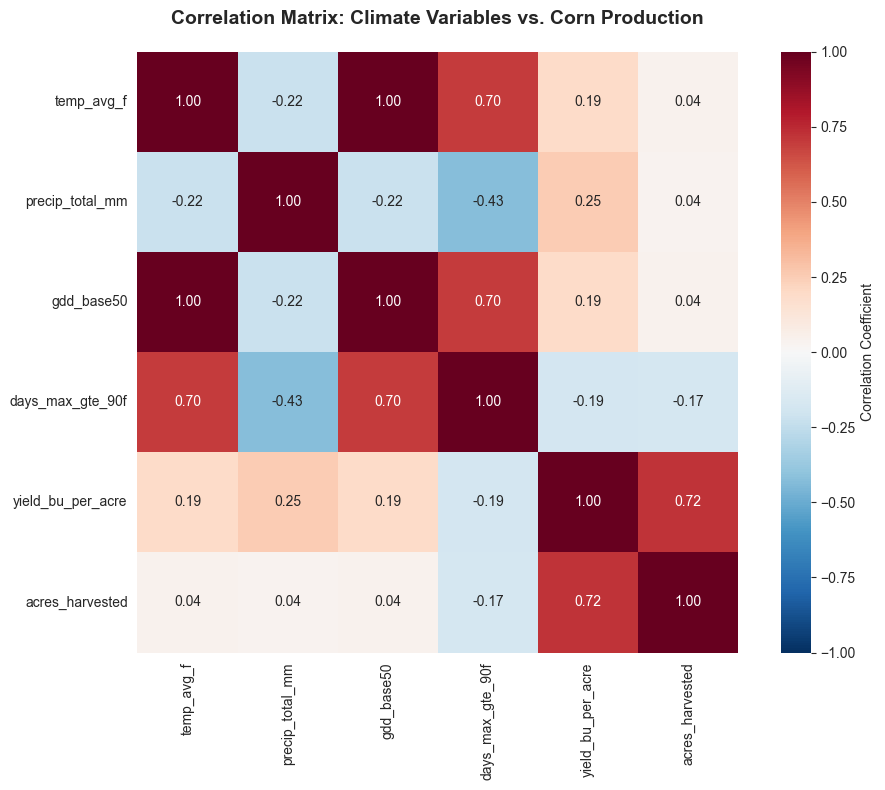

In [4]:
print("\nCorrelating climate variables with corn yield")

#select climate predictors
climate_predictors = [
    'temp_avg_f', 'temp_max_f', 'temp_min_f',
    'precip_total_mm', 'gdd_base50', 
    'days_max_gte_90f', 'days_min_lte_32f'
]

#filter to available columns
available_predictors = [col for col in climate_predictors if col in df_integrated.columns]

if 'yield_bu_per_acre' in df_integrated.columns:
    print("\nPearson correlations with corn yield:")
    print(f"{'Variable':<25} {'Correlation':>12} {'P-value':>12} {'Significance':>15}")
    print("-" * 70)
    
    correlations = []
    for var in available_predictors:
        # Calculate correlation
        mask = df_integrated[[var, 'yield_bu_per_acre']].notna().all(axis=1)
        if mask.sum() > 2:
            corr, pval = pearsonr(
                df_integrated.loc[mask, var],
                df_integrated.loc[mask, 'yield_bu_per_acre']
            )
            
            # Significance stars
            if pval < 0.001:
                sig = '***'
            elif pval < 0.01:
                sig = '**'
            elif pval < 0.05:
                sig = '*'
            else:
                sig = 'ns'
            
            print(f"{var:<25} {corr:>12.3f} {pval:>12.4f} {sig:>15}")
            correlations.append({'variable': var, 'correlation': corr, 'pvalue': pval})
    
    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


print("\nCreate correlation matrix heatmap")

#select our subset of key variables
heatmap_vars = ['temp_avg_f', 'precip_total_mm', 'gdd_base50', 
                'days_max_gte_90f', 'yield_bu_per_acre', 'acres_harvested']
heatmap_vars = [col for col in heatmap_vars if col in df_integrated.columns]

if len(heatmap_vars) >= 3:
    # calculate correlation matrix
    corr_matrix = df_integrated[heatmap_vars].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax)
    
    plt.title('Correlation Matrix: Climate Variables vs. Corn Production', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()




Creating time series visualizations


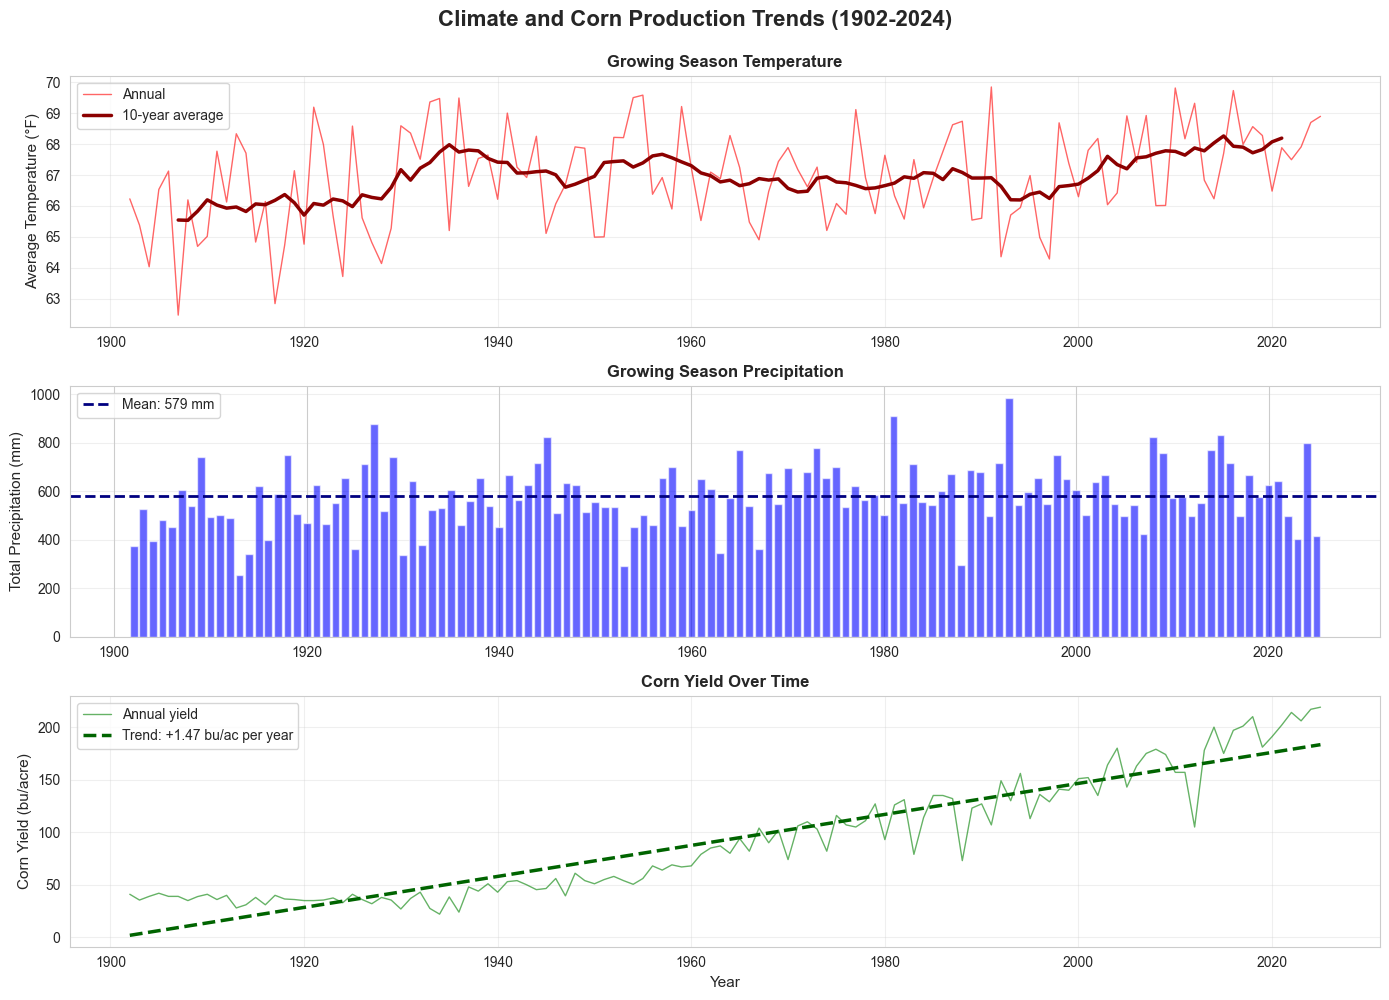

In [5]:
print("\nCreating time series visualizations")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Climate and Corn Production Trends (1902-2024)', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Temperature
if 'temp_avg_f' in df_integrated.columns:
    axes[0].plot(df_integrated['year'], df_integrated['temp_avg_f'], 
                 color='red', linewidth=1, alpha=0.6, label='Annual')
    
    # Add 10-year moving average
    moving_avg = df_integrated['temp_avg_f'].rolling(window=10, center=True).mean()
    axes[0].plot(df_integrated['year'], moving_avg, 
                 color='darkred', linewidth=2.5, label='10-year average')
    
    axes[0].set_ylabel('Average Temperature (°F)', fontsize=11)
    axes[0].set_title('Growing Season Temperature', fontsize=12, fontweight='bold')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)

# Plot 2: Precipitation
if 'precip_total_mm' in df_integrated.columns:
    axes[1].bar(df_integrated['year'], df_integrated['precip_total_mm'], 
                color='blue', alpha=0.6, width=0.8)
    axes[1].axhline(y=df_integrated['precip_total_mm'].mean(), 
                    color='navy', linestyle='--', linewidth=2, 
                    label=f"Mean: {df_integrated['precip_total_mm'].mean():.0f} mm")
    
    axes[1].set_ylabel('Total Precipitation (mm)', fontsize=11)
    axes[1].set_title('Growing Season Precipitation', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper left')
    axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Corn Yield
if 'yield_bu_per_acre' in df_integrated.columns:
    axes[2].plot(df_integrated['year'], df_integrated['yield_bu_per_acre'], 
                 color='green', linewidth=1, alpha=0.6, label='Annual yield')
    
    # Add trend line
    z = np.polyfit(df_integrated['year'], df_integrated['yield_bu_per_acre'], 1)
    p = np.poly1d(z)
    axes[2].plot(df_integrated['year'], p(df_integrated['year']), 
                 color='darkgreen', linewidth=2.5, linestyle='--', 
                 label=f'Trend: +{z[0]:.2f} bu/ac per year')
    
    axes[2].set_xlabel('Year', fontsize=11)
    axes[2].set_ylabel('Corn Yield (bu/acre)', fontsize=11)
    axes[2].set_title('Corn Yield Over Time', fontsize=12, fontweight='bold')
    axes[2].legend(loc='upper left')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()


Creating scatter plots of climate vs. yield


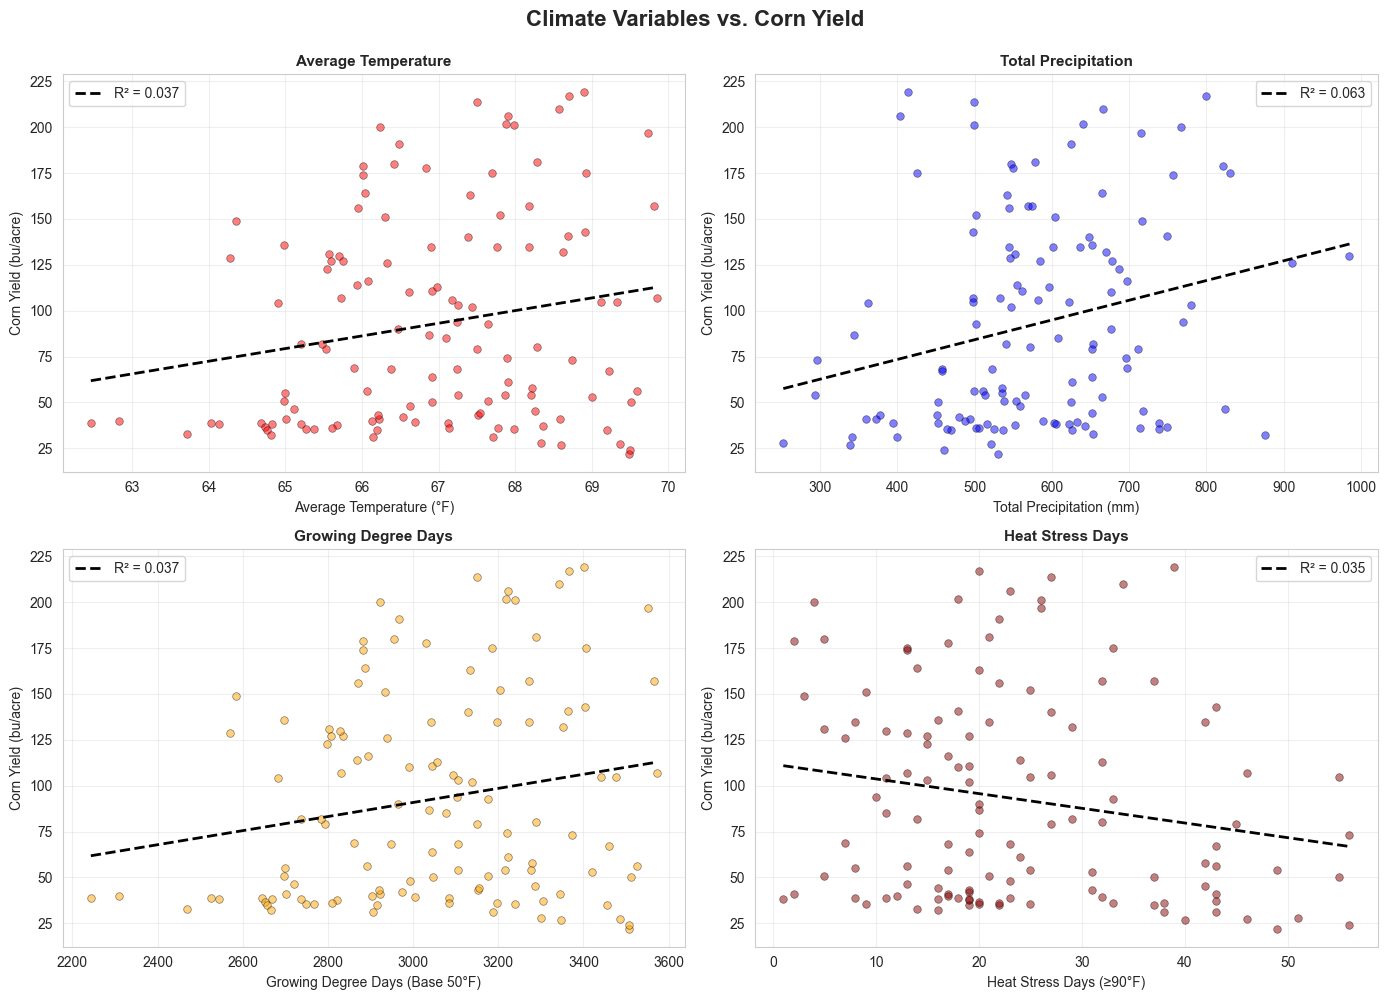

In [6]:
print("\nCreating scatter plots of climate vs. yield")

scatter_vars = [
    ('temp_avg_f', 'Average Temperature (°F)', 'red'),
    ('precip_total_mm', 'Total Precipitation (mm)', 'blue'),
    ('gdd_base50', 'Growing Degree Days (Base 50°F)', 'orange'),
    ('days_max_gte_90f', 'Heat Stress Days (≥90°F)', 'darkred')
]

scatter_vars = [(var, label, color) for var, label, color in scatter_vars 
                if var in df_integrated.columns]

if scatter_vars and 'yield_bu_per_acre' in df_integrated.columns:
    n_plots = len(scatter_vars)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    fig.suptitle('Climate Variables vs. Corn Yield', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, (var, label, color) in enumerate(scatter_vars[:4]):
        ax = axes[idx]
        
        ax.scatter(df_integrated[var], df_integrated['yield_bu_per_acre'],
                  alpha=0.5, s=30, color=color, edgecolors='black', linewidth=0.5)
        
        mask = df_integrated[[var, 'yield_bu_per_acre']].notna().all(axis=1)
        if mask.sum() > 2:
            x = df_integrated.loc[mask, var].values.reshape(-1, 1)
            y = df_integrated.loc[mask, 'yield_bu_per_acre'].values
            
            model = LinearRegression()
            model.fit(x, y)
            
            x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_line = model.predict(x_line)
            
            ax.plot(x_line, y_line, color='black', linewidth=2, 
                   linestyle='--', label=f'R² = {r2_score(y, model.predict(x)):.3f}')
        
        ax.set_xlabel(label, fontsize=10)
        ax.set_ylabel('Corn Yield (bu/acre)', fontsize=10)
        ax.set_title(f'{label.split("(")[0].strip()}', fontsize=11, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()


In [7]:
print("\n[Step 5.1] Simple linear regression models...")

regression_vars = [
    ('temp_avg_f', 'Average Temperature'),
    ('precip_total_mm', 'Total Precipitation'),
    ('gdd_base50', 'Growing Degree Days')
]

regression_results = []

if 'yield_bu_per_acre' in df_integrated.columns:
    print(f"\n{'Predictor':<30} {'R²':>8} {'RMSE':>10} {'Coef':>10} {'P-value':>10}")
    print("-" * 70)
    
    for var, description in regression_vars:
        if var in df_integrated.columns:
            # Prepare data
            mask = df_integrated[[var, 'yield_bu_per_acre']].notna().all(axis=1)
            X = df_integrated.loc[mask, var].values.reshape(-1, 1)
            y = df_integrated.loc[mask, 'yield_bu_per_acre'].values
            
            if len(X) > 2:
                # Fit model
                model = LinearRegression()
                model.fit(X, y)
                
                # Predictions
                y_pred = model.predict(X)
                
                # Metrics
                r2 = r2_score(y, y_pred)
                rmse = np.sqrt(mean_squared_error(y, y_pred))
                coef = model.coef_[0]
                
                # Calculate p-value
                _, pval = pearsonr(X.flatten(), y)
                
                print(f"{description:<30} {r2:>8.3f} {rmse:>10.2f} {coef:>10.3f} {pval:>10.4f}")
                
                regression_results.append({
                    'predictor': var,
                    'description': description,
                    'r2': r2,
                    'rmse': rmse,
                    'coefficient': coef,
                    'pvalue': pval
                })

print("\nMultiple linear regression model")

# Select predictors
mlr_predictors = ['temp_avg_f', 'precip_total_mm', 'gdd_base50', 'days_max_gte_90f']
mlr_predictors = [col for col in mlr_predictors if col in df_integrated.columns]

if len(mlr_predictors) >= 2 and 'yield_bu_per_acre' in df_integrated.columns:
    # Prepare data
    data_cols = mlr_predictors + ['yield_bu_per_acre']
    mask = df_integrated[data_cols].notna().all(axis=1)
    
    X_multi = df_integrated.loc[mask, mlr_predictors].values
    y_multi = df_integrated.loc[mask, 'yield_bu_per_acre'].values
    
    if len(X_multi) > len(mlr_predictors) + 1:
        # Fit model
        model_multi = LinearRegression()
        model_multi.fit(X_multi, y_multi)
        
        # Predictions
        y_pred_multi = model_multi.predict(X_multi)
        
        # Metrics
        r2_multi = r2_score(y_multi, y_pred_multi)
        rmse_multi = np.sqrt(mean_squared_error(y_multi, y_pred_multi))
        
        print(f"\nMultiple regression model:")
        print(f"  Predictors: {', '.join(mlr_predictors)}")
        print(f"  R² = {r2_multi:.3f}")
        print(f"  RMSE = {rmse_multi:.2f} bu/acre")
        print(f"  Sample size: {len(X_multi)} years")
        
        print(f"\n  Coefficients:")
        for idx, pred in enumerate(mlr_predictors):
            print(f"    {pred}: {model_multi.coef_[idx]:.4f}")
        print(f"    Intercept: {model_multi.intercept_:.2f}")





[Step 5.1] Simple linear regression models...

Predictor                            R²       RMSE       Coef    P-value
----------------------------------------------------------------------
Average Temperature               0.037      55.19      6.900     0.0313
Total Precipitation               0.063      54.45      0.108     0.0050
Growing Degree Days               0.037      55.19      0.038     0.0312

Multiple linear regression model

Multiple regression model:
  Predictors: temp_avg_f, precip_total_mm, gdd_base50, days_max_gte_90f
  R² = 0.261
  RMSE = 48.35 bu/acre
  Sample size: 124 years

  Coefficients:
    temp_avg_f: -1160.8975
    precip_total_mm: 0.0655
    gdd_base50: 6.5713
    days_max_gte_90f: -2.3296
    Intercept: 57784.58


In [8]:
print("\nIdentifying extreme weather and yield years")

if 'yield_bu_per_acre' in df_integrated.columns:
    #thresholds (bottom/top 10%)
    yield_10th = df_integrated['yield_bu_per_acre'].quantile(0.10)
    yield_90th = df_integrated['yield_bu_per_acre'].quantile(0.90)
    
    low_yield_years = df_integrated[df_integrated['yield_bu_per_acre'] <= yield_10th]
    high_yield_years = df_integrated[df_integrated['yield_bu_per_acre'] >= yield_90th]
    
    print(f"\nLow yield years (bottom 10%, ≤{yield_10th:.1f} bu/acre):")
    display_cols_low = ['year', 'yield_bu_per_acre', 'temp_avg_f', 'precip_total_mm']
    available_cols_low = [c for c in display_cols_low if c in low_yield_years.columns]
    print(low_yield_years[available_cols_low].sort_values('yield_bu_per_acre'))
    
    print(f"\nHigh yield years (top 10%, ≥{yield_90th:.1f} bu/acre):")
    print(high_yield_years[available_cols_low].sort_values('yield_bu_per_acre', ascending=False))



Identifying extreme weather and yield years

Low yield years (bottom 10%, ≤35.5 bu/acre):
    year  yield_bu_per_acre  temp_avg_f  precip_total_mm
32  1934               22.1      69.479            529.7
34  1936               24.0      69.494            460.8
28  1930               27.0      68.594            338.2
31  1933               27.5      69.365            521.5
11  1913               28.0      68.336            252.4
12  1914               31.0      67.709            340.8
14  1916               31.0      66.143            399.8
25  1927               32.0      64.814            875.3
22  1924               33.0      63.713            653.3
6   1908               35.0      66.194            536.9
18  1920               35.0      64.760            469.6
19  1921               35.0      69.197            626.4
1   1903               35.5      65.378            525.2
20  1922               35.5      67.988            464.2
27  1929               35.5      65.273            738

In [9]:
print(f"\nDataset summary:")
print(f"  Integrated years: {len(df_integrated)}")
print(f"  Year range: {df_integrated['year'].min()}-{df_integrated['year'].max()}")
print(f"  Climate variables: {len([c for c in df_integrated.columns if any(x in c for x in ['temp_', 'precip_', 'gdd_'])])}")
print(f"  Corn variables: {len([c for c in df_integrated.columns if 'yield' in c or 'acres' in c or 'production' in c])}")

print(f"\nKey findings:")
if correlations:
    sorted_corrs = sorted(correlations, key=lambda x: abs(x['correlation']), reverse=True)
    print(f"  Strongest climate-yield correlation: {sorted_corrs[0]['variable']}")
    print(f"    r = {sorted_corrs[0]['correlation']:.3f}, p = {sorted_corrs[0]['pvalue']:.4f}")

print(f"\nOutput files generated:")
print(f"integrated_climate_corn.csv")



Dataset summary:
  Integrated years: 124
  Year range: 1902-2025
  Climate variables: 9
  Corn variables: 4

Key findings:
  Strongest climate-yield correlation: precip_total_mm
    r = 0.251, p = 0.0050

Output files generated:
integrated_climate_corn.csv
